In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.utils import resample
from scipy import stats
from sklearn.utils import resample
from scipy import stats
from imblearn.over_sampling import SMOTE, ADASYN
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

2024-04-18 16:54:52.747528: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 16:54:52.747628: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 16:54:52.868297: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Processing

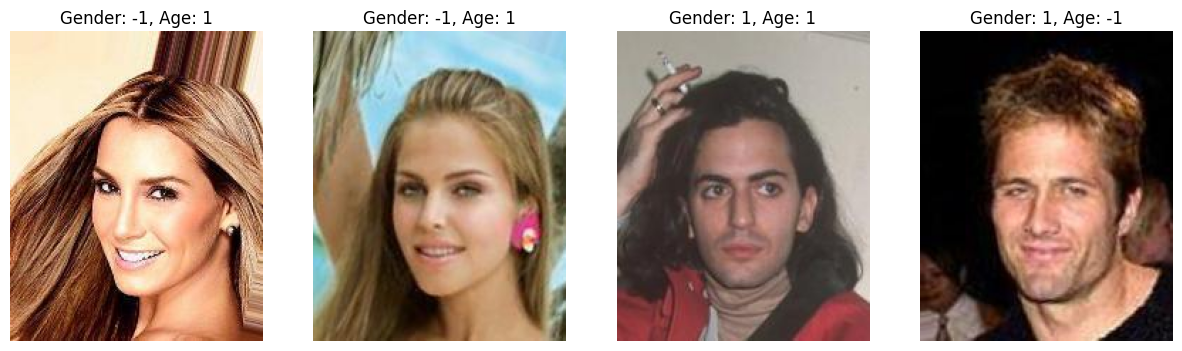

In [3]:
# Load CelebA dataset attributes
attributes_path = '/kaggle/input/dataset/list_attr_celeba.csv'
attributes_df = pd.read_csv(attributes_path)

# Sample images and labels
sample_indices = [0, 1000, 2000, 3000]  # Sample indices
sample_df = attributes_df.iloc[sample_indices]

# Visualize sample images
images_dir = '/kaggle/input/dataset/img_align_celeba/img_align_celeba'
plt.figure(figsize=(15, 5))
for i, idx in enumerate(sample_indices):
    plt.subplot(1, 4, i+1)
    img_path = os.path.join(images_dir, attributes_df.iloc[idx]['image_id'])
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f"Gender: {sample_df.iloc[i]['Male']}, Age: {sample_df.iloc[i]['Young']}")
    plt.axis('off')
plt.show()


# Bias Detection

In [4]:
# Identify underrepresented group (e.g., 'Male' in 'Male' column)
underrepresented_group = 1  # 1 represents Male in CelebA dataset

# Calculate imbalance ratio
total_count = len(attributes_df)
underrepresented_count = len(attributes_df[attributes_df['Male'] == underrepresented_group])
overrepresented_count = total_count - underrepresented_count
imbalance_ratio = underrepresented_count / overrepresented_count

print(f"Imbalance Ratio: {imbalance_ratio:.2f}")

Imbalance Ratio: 0.71


### Chi-Squared Test for gender distribution

In [5]:
observed_values = [underrepresented_count, overrepresented_count]
expected_values = [total_count / 2, total_count / 2]  # Expected equal distribution
chi2_stat, p_val = stats.chisquare(observed_values, f_exp=expected_values)

print(f"Chi-Squared Test Statistic: {chi2_stat:.2f}")
print(f"P-value: {p_val:.4f}")

Chi-Squared Test Statistic: 5615.92
P-value: 0.0000


### Mean differences between groups for each attribute

In [6]:
mean_diffs = {}
for column in attributes_df.drop(columns=['image_id', 'Male']).columns:
    mean_diff = attributes_df[attributes_df['Male'] == underrepresented_group][column].mean() - \
                attributes_df[attributes_df['Male'] != underrepresented_group][column].mean()
    mean_diffs[column] = mean_diff

print("\nMean Differences:")
for attribute, mean_diff in mean_diffs.items():
    print(f"{attribute}: {mean_diff:.2f}")


Mean Differences:
5_o_Clock_Shadow: 0.53
Arched_Eyebrows: -0.73
Attractive: -0.80
Bags_Under_Eyes: 0.49
Bald: 0.11
Bangs: -0.24
Big_Lips: -0.29
Big_Nose: 0.63
Black_Hair: 0.20
Blond_Hair: -0.44
Blurry: 0.02
Brown_Hair: -0.18
Bushy_Eyebrows: 0.35
Chubby: 0.22
Double_Chin: 0.18
Eyeglasses: 0.20
Goatee: 0.30
Gray_Hair: 0.15
Heavy_Makeup: -1.32
High_Cheekbones: -0.51
Mouth_Slightly_Open: -0.20
Mustache: 0.20
Narrow_Eyes: 0.02
No_Beard: -0.79
Oval_Face: -0.22
Pale_Skin: -0.06
Pointy_Nose: -0.39
Receding_Hairline: 0.13
Rosy_Cheeks: -0.22
Sideburns: 0.27
Smiling: -0.28
Straight_Hair: 0.12
Wavy_Hair: -0.61
Wearing_Earrings: -0.59
Wearing_Hat: 0.11
Wearing_Lipstick: -1.60
Wearing_Necklace: -0.36
Wearing_Necktie: 0.35
Young: -0.48


### Variance ratios between groups for each attribute

In [7]:
variance_ratios = {}
for column in attributes_df.drop(columns=['image_id', 'Male']).columns:
    variance_ratio = attributes_df[attributes_df['Male'] == underrepresented_group][column].var() / \
                     attributes_df[attributes_df['Male'] != underrepresented_group][column].var()
    variance_ratios[column] = variance_ratio

print("\nVariance Ratios:")
for attribute, variance_ratio in variance_ratios.items():
    print(f"{attribute}: {variance_ratio:.2f}")




Variance Ratios:
5_o_Clock_Shadow: 1154.95
Arched_Eyebrows: 0.21
Attractive: 0.92
Bags_Under_Eyes: 2.48
Bald: 352.97
Bangs: 0.47
Big_Lips: 0.63
Big_Nose: 2.65
Black_Hair: 1.32
Blond_Hair: 0.11
Blurry: 1.22
Brown_Hair: 0.70
Bushy_Eyebrows: 2.86
Chubby: 8.84
Double_Chin: 9.26
Eyeglasses: 4.84
Goatee: 1161.91
Gray_Hair: 7.40
Heavy_Makeup: 0.01
High_Cheekbones: 0.86
Mouth_Slightly_Open: 0.98
Mustache: 3534.07
Narrow_Eyes: 1.07
No_Beard: 203.29
Oval_Face: 0.78
Pale_Skin: 0.45
Pointy_Nose: 0.59
Receding_Hairline: 2.07
Rosy_Cheeks: 0.03
Sideburns: 1258.21
Smiling: 0.97
Straight_Hair: 1.22
Wavy_Hair: 0.49
Wearing_Earrings: 0.07
Wearing_Hat: 3.07
Wearing_Lipstick: 0.04
Wearing_Necklace: 0.11
Wearing_Necktie: 485.52
Young: 2.11


### Pearson correlation between gender and each attribute

In [8]:
correlations = {}
for column in attributes_df.drop(columns=['image_id']).columns:
    correlation = attributes_df['Male'].corr(attributes_df[column])
    correlations[column] = correlation

print("\nCorrelations with Gender:")
for attribute, correlation in correlations.items():
    print(f"{attribute}: {correlation:.2f}")


Correlations with Gender:
5_o_Clock_Shadow: 0.42
Arched_Eyebrows: -0.41
Attractive: -0.39
Bags_Under_Eyes: 0.30
Bald: 0.18
Bangs: -0.16
Big_Lips: -0.17
Big_Nose: 0.37
Black_Hair: 0.12
Blond_Hair: -0.30
Blurry: 0.02
Brown_Hair: -0.11
Bushy_Eyebrows: 0.25
Chubby: 0.23
Double_Chin: 0.21
Eyeglasses: 0.20
Goatee: 0.31
Gray_Hair: 0.18
Heavy_Makeup: -0.67
High_Cheekbones: -0.25
Male: 1.00
Mouth_Slightly_Open: -0.10
Mustache: 0.25
Narrow_Eyes: 0.01
No_Beard: -0.52
Oval_Face: -0.12
Pale_Skin: -0.08
Pointy_Nose: -0.22
Receding_Hairline: 0.12
Rosy_Cheeks: -0.21
Sideburns: 0.29
Smiling: -0.14
Straight_Hair: 0.07
Wavy_Hair: -0.32
Wearing_Earrings: -0.37
Wearing_Hat: 0.13
Wearing_Lipstick: -0.79
Wearing_Necklace: -0.27
Wearing_Necktie: 0.33
Young: -0.28


# Visualizing Detected Biases

### Visualize attribute distribution

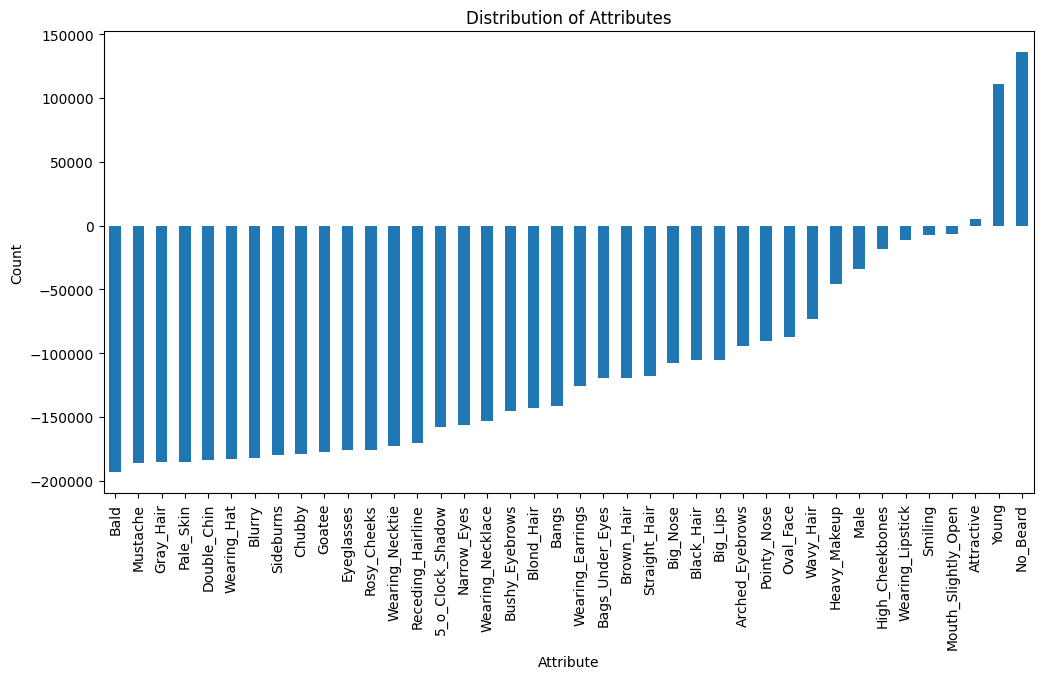

In [9]:
attribute_distribution = attributes_df.drop(columns=['image_id']).sum(axis=0)

plt.figure(figsize=(12, 6))
attribute_distribution.sort_values().plot(kind='bar')
plt.title('Distribution of Attributes')
plt.xlabel('Attribute')
plt.ylabel('Count')
plt.show()


### Visualize gender distribution

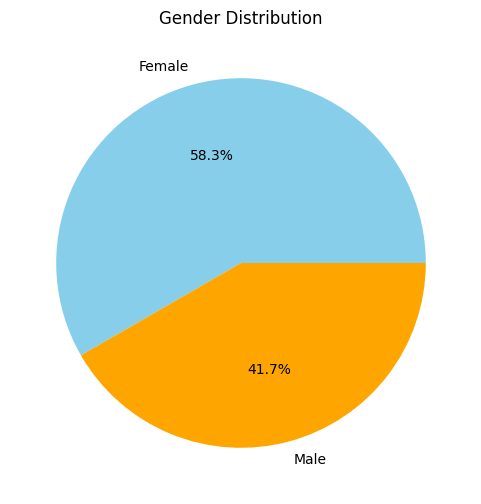

In [10]:
gender_distribution = attributes_df['Male'].value_counts()

plt.figure(figsize=(6, 6))
gender_distribution.plot(kind='pie', autopct='%1.1f%%', labels=['Female', 'Male'], colors=['skyblue', 'orange'])
plt.title('Gender Distribution')
plt.ylabel('')
plt.show()

### Visualize gender and age correlation

<Figure size 800x600 with 0 Axes>

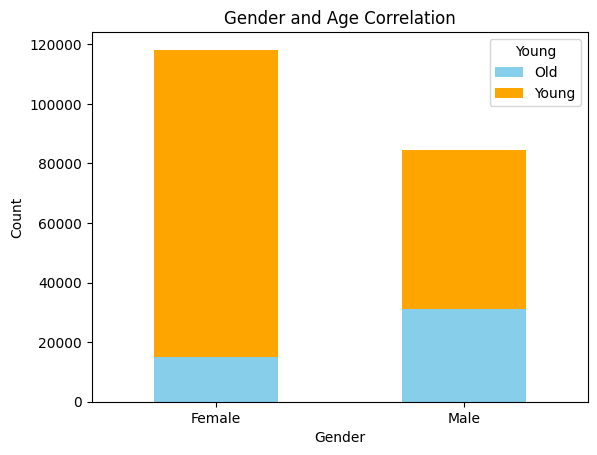

In [11]:
age_gender_corr = attributes_df.groupby('Male')['Young'].value_counts().unstack()

plt.figure(figsize=(8, 6))
age_gender_corr.plot(kind='bar', stacked=True, color=['skyblue', 'orange'])
plt.title('Gender and Age Correlation')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Female', 'Male'], rotation=0)
plt.legend(title='Young', labels=['Old', 'Young'])
plt.show()

### Visualize attribute correlation matrix

<Figure size 1200x800 with 0 Axes>

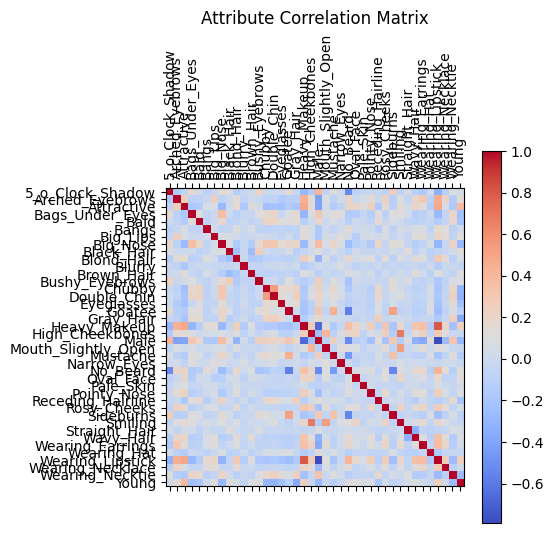

In [12]:
attributes_corr = attributes_df.drop(columns=['image_id']).corr()

plt.figure(figsize=(12, 8))
plt.matshow(attributes_corr, cmap='coolwarm')
plt.title('Attribute Correlation Matrix')
plt.colorbar()
plt.xticks(range(len(attributes_corr.columns)), attributes_corr.columns, rotation=90)
plt.yticks(range(len(attributes_corr.columns)), attributes_corr.columns)
plt.show()


### Visualize gender and other attribute correlation

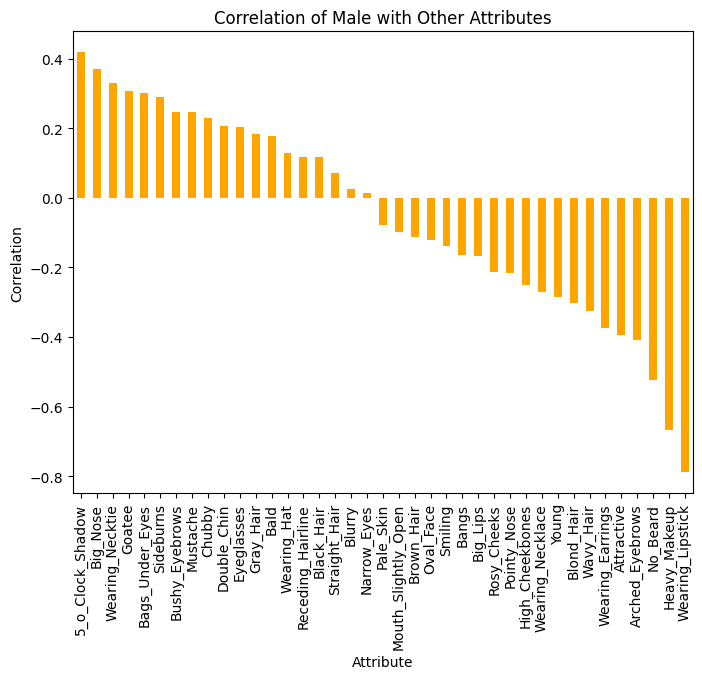

In [13]:
gender_attr_corr = attributes_df.drop(columns=['image_id']).corr()['Male'].sort_values(ascending=False)

plt.figure(figsize=(8, 6))
gender_attr_corr.drop('Male').plot(kind='bar', color='orange')
plt.title('Correlation of Male with Other Attributes')
plt.xlabel('Attribute')
plt.ylabel('Correlation')
plt.show()

# Bias Mitigation

In [14]:
underrepresented_group = 1  # 1 represents Male in CelebA dataset

male_data = attributes_df[attributes_df['Male'] == underrepresented_group]
female_data = attributes_df[attributes_df['Male'] != underrepresented_group]

print("Original Data Distribution:")
print("Male Count:", len(male_data))
print("Female Count:", len(female_data))

oversampled_male_data = resample(male_data, replace=True, n_samples=len(female_data), random_state=42)

balanced_data = pd.concat([female_data, oversampled_male_data])

print("\nBalanced Data Distribution:")
print("Male Count:", len(oversampled_male_data))
print("Female Count:", len(female_data))

Original Data Distribution:
Male Count: 84434
Female Count: 118165

Balanced Data Distribution:
Male Count: 118165
Female Count: 118165


# Quantitative and Qualitative Analyzing new mitigated datset

### Calculate imbalance ratio

In [15]:
total_count = len(balanced_data)
underrepresented_count = len(balanced_data[balanced_data['Male'] == underrepresented_group])
overrepresented_count = total_count - underrepresented_count
imbalance_ratio = underrepresented_count / overrepresented_count

print(f"Imbalance Ratio after Resampling: {imbalance_ratio:.2f}")

Imbalance Ratio after Resampling: 1.00


### Chi-Squared Test

In [16]:
observed_values = [underrepresented_count, overrepresented_count]
expected_values = [total_count / 2, total_count / 2]  # Expected equal distribution
chi2_stat, p_val = stats.chisquare(observed_values, f_exp=expected_values)

print(f"Chi-Squared Test Statistic after Resampling: {chi2_stat:.2f}")
print(f"P-value after Resampling: {p_val:.4f}")

Chi-Squared Test Statistic after Resampling: 0.00
P-value after Resampling: 1.0000


### Calculate mean differences between groups for each attribute

In [17]:
mean_diffs_after_resampling = {}
for column in balanced_data.drop(columns=['image_id', 'Male']).columns:
    mean_diff = balanced_data[balanced_data['Male'] == underrepresented_group][column].mean() - \
                balanced_data[balanced_data['Male'] != underrepresented_group][column].mean()
    mean_diffs_after_resampling[column] = mean_diff

print("\nMean Differences after Resampling:")
for attribute, mean_diff in mean_diffs_after_resampling.items():
    print(f"{attribute}: {mean_diff:.2f}")


Mean Differences after Resampling:
5_o_Clock_Shadow: 0.53
Arched_Eyebrows: -0.73
Attractive: -0.80
Bags_Under_Eyes: 0.49
Bald: 0.11
Bangs: -0.24
Big_Lips: -0.29
Big_Nose: 0.64
Black_Hair: 0.21
Blond_Hair: -0.44
Blurry: 0.02
Brown_Hair: -0.19
Bushy_Eyebrows: 0.35
Chubby: 0.22
Double_Chin: 0.18
Eyeglasses: 0.20
Goatee: 0.30
Gray_Hair: 0.15
Heavy_Makeup: -1.32
High_Cheekbones: -0.50
Mouth_Slightly_Open: -0.20
Mustache: 0.20
Narrow_Eyes: 0.02
No_Beard: -0.79
Oval_Face: -0.22
Pale_Skin: -0.06
Pointy_Nose: -0.39
Receding_Hairline: 0.13
Rosy_Cheeks: -0.21
Sideburns: 0.27
Smiling: -0.28
Straight_Hair: 0.12
Wavy_Hair: -0.62
Wearing_Earrings: -0.59
Wearing_Hat: 0.11
Wearing_Lipstick: -1.60
Wearing_Necklace: -0.36
Wearing_Necktie: 0.35
Young: -0.48


### Calculate variance ratios between groups for each attribute

In [18]:
variance_ratios_after_resampling = {}
for column in balanced_data.drop(columns=['image_id', 'Male']).columns:
    variance_ratio = balanced_data[balanced_data['Male'] == underrepresented_group][column].var() / \
                     balanced_data[balanced_data['Male'] != underrepresented_group][column].var()
    variance_ratios_after_resampling[column] = variance_ratio

print("\nVariance Ratios after Resampling:")
for attribute, variance_ratio in variance_ratios_after_resampling.items():
    print(f"{attribute}: {variance_ratio:.2f}")


Variance Ratios after Resampling:
5_o_Clock_Shadow: 1153.84
Arched_Eyebrows: 0.21
Attractive: 0.92
Bags_Under_Eyes: 2.48
Bald: 357.91
Bangs: 0.48
Big_Lips: 0.63
Big_Nose: 2.65
Black_Hair: 1.33
Blond_Hair: 0.11
Blurry: 1.23
Brown_Hair: 0.70
Bushy_Eyebrows: 2.88
Chubby: 8.87
Double_Chin: 9.29
Eyeglasses: 4.82
Goatee: 1169.92
Gray_Hair: 7.42
Heavy_Makeup: 0.01
High_Cheekbones: 0.87
Mouth_Slightly_Open: 0.98
Mustache: 3574.21
Narrow_Eyes: 1.07
No_Beard: 203.22
Oval_Face: 0.78
Pale_Skin: 0.44
Pointy_Nose: 0.59
Receding_Hairline: 2.07
Rosy_Cheeks: 0.03
Sideburns: 1245.82
Smiling: 0.97
Straight_Hair: 1.23
Wavy_Hair: 0.49
Wearing_Earrings: 0.07
Wearing_Hat: 3.08
Wearing_Lipstick: 0.04
Wearing_Necklace: 0.11
Wearing_Necktie: 484.88
Young: 2.11


### Calculating Pearson correlation between gender and each attribute

In [19]:
correlations_after_resampling = {}
for column in balanced_data.drop(columns=['image_id']).columns:
    correlation = balanced_data['Male'].corr(balanced_data[column])
    correlations_after_resampling[column] = correlation

print("\nCorrelations with Gender after Resampling:")
for attribute, correlation in correlations_after_resampling.items():
    print(f"{attribute}: {correlation:.2f}")


Correlations with Gender after Resampling:
5_o_Clock_Shadow: 0.39
Arched_Eyebrows: -0.43
Attractive: -0.40
Bags_Under_Eyes: 0.30
Bald: 0.17
Bangs: -0.17
Big_Lips: -0.17
Big_Nose: 0.36
Black_Hair: 0.12
Blond_Hair: -0.33
Blurry: 0.03
Brown_Hair: -0.12
Bushy_Eyebrows: 0.24
Chubby: 0.22
Double_Chin: 0.20
Eyeglasses: 0.19
Goatee: 0.29
Gray_Hair: 0.18
Heavy_Makeup: -0.70
High_Cheekbones: -0.25
Male: 1.00
Mouth_Slightly_Open: -0.10
Mustache: 0.23
Narrow_Eyes: 0.01
No_Beard: -0.49
Oval_Face: -0.12
Pale_Skin: -0.08
Pointy_Nose: -0.22
Receding_Hairline: 0.12
Rosy_Cheeks: -0.23
Sideburns: 0.27
Smiling: -0.14
Straight_Hair: 0.07
Wavy_Hair: -0.34
Wearing_Earrings: -0.40
Wearing_Hat: 0.13
Wearing_Lipstick: -0.81
Wearing_Necklace: -0.29
Wearing_Necktie: 0.31
Young: -0.28


### Visualizing attribute distribution after mitigation

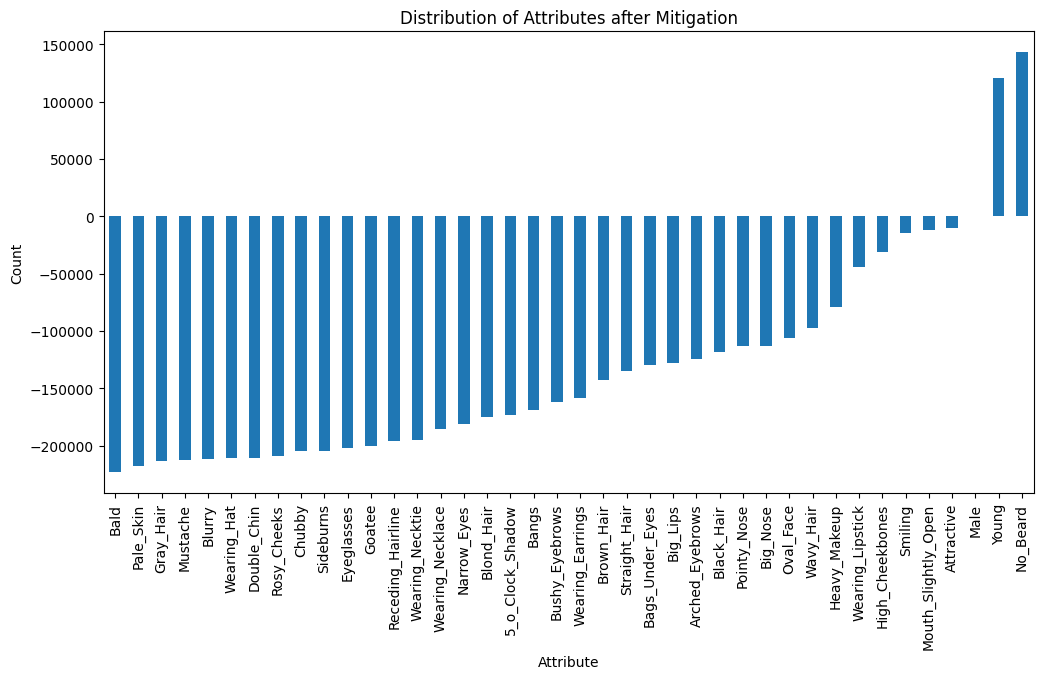

In [20]:
attribute_distribution_after = balanced_data.drop(columns=['image_id']).sum(axis=0)

plt.figure(figsize=(12, 6))
attribute_distribution_after.sort_values().plot(kind='bar')
plt.title('Distribution of Attributes after Mitigation')
plt.xlabel('Attribute')
plt.ylabel('Count')
plt.show()

### Gender Distribution

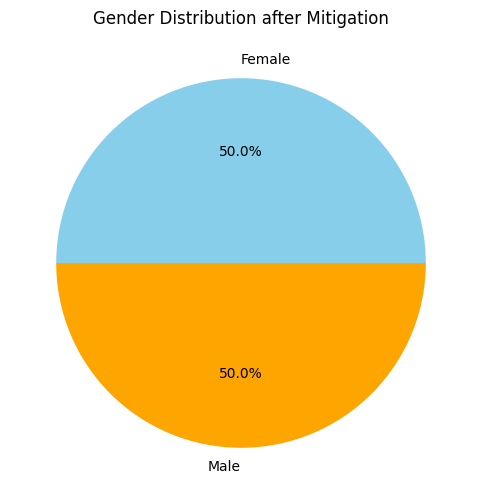

In [21]:
gender_distribution_after = balanced_data['Male'].value_counts()

plt.figure(figsize=(6, 6))
gender_distribution_after.plot(kind='pie', autopct='%1.1f%%', labels=['Female', 'Male'], colors=['skyblue', 'orange'])
plt.title('Gender Distribution after Mitigation')
plt.ylabel('')
plt.show()


### Gender and Age correlation after mitigation

<Figure size 800x600 with 0 Axes>

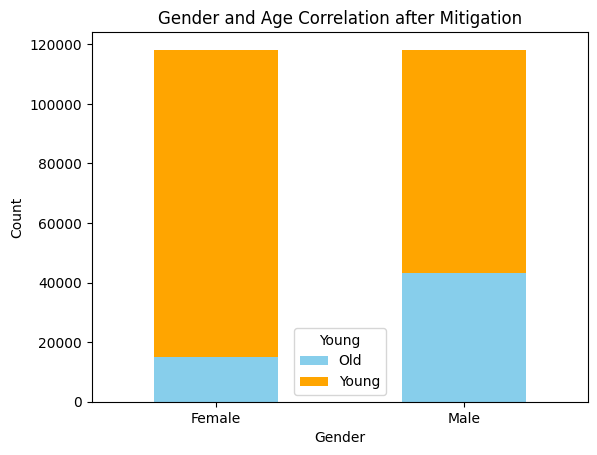

In [22]:
age_gender_corr_after = balanced_data.groupby('Male')['Young'].value_counts().unstack()

plt.figure(figsize=(8, 6))
age_gender_corr_after.plot(kind='bar', stacked=True, color=['skyblue', 'orange'])
plt.title('Gender and Age Correlation after Mitigation')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Female', 'Male'], rotation=0)
plt.legend(title='Young', labels=['Old', 'Young'])
plt.show()

### Visualize attribute correlation matrix after mitigation

<Figure size 1200x800 with 0 Axes>

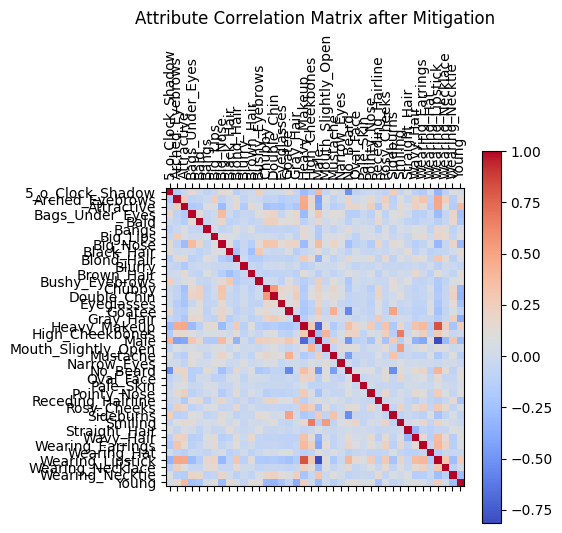

In [23]:
attributes_corr_after = balanced_data.drop(columns=['image_id']).corr()

plt.figure(figsize=(12, 8))
plt.matshow(attributes_corr_after, cmap='coolwarm')
plt.title('Attribute Correlation Matrix after Mitigation')
plt.colorbar()
plt.xticks(range(len(attributes_corr_after.columns)), attributes_corr_after.columns, rotation=90)
plt.yticks(range(len(attributes_corr_after.columns)), attributes_corr_after.columns)
plt.show()

### Visualize gender and other attribute correlation after mitigation

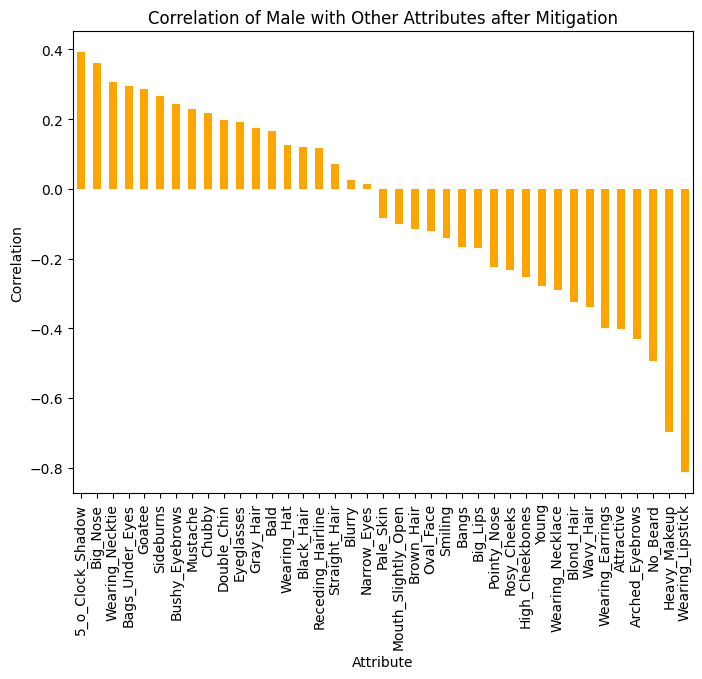

In [24]:
# Gender and other attribute correlation after mitigation
gender_attr_corr_after = balanced_data.drop(columns=['image_id']).corr()['Male'].sort_values(ascending=False)

plt.figure(figsize=(8, 6))
gender_attr_corr_after.drop('Male').plot(kind='bar', color='orange')
plt.title('Correlation of Male with Other Attributes after Mitigation')
plt.xlabel('Attribute')
plt.ylabel('Correlation')
plt.show()


## SMOTE Analysis

In [25]:
X = balanced_data.drop(columns=['image_id', 'Male'])
y = balanced_data['Male']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("SMOTE Data Distribution:")
print("Male Count:", len(y_train_resampled[y_train_resampled == underrepresented_group]))
print("Female Count:", len(y_train_resampled[y_train_resampled != underrepresented_group]))


SMOTE Data Distribution:
Male Count: 94750
Female Count: 94750


# Evaluating Precitions using Random Forest Classfier

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize Random Forest classifier
clf = RandomForestClassifier(random_state=42)

# Fit the model on resampled data
clf.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9493716413489612

Classification Report:
               precision    recall  f1-score   support

          -1       0.97      0.93      0.95     23415
           1       0.93      0.97      0.95     23851

    accuracy                           0.95     47266
   macro avg       0.95      0.95      0.95     47266
weighted avg       0.95      0.95      0.95     47266

